# Composable Blocks & Interactive Charts

This notebook is a simple illustration of the python API for Blocks and Highcharts interactive charts.

**What are Blocks?**
Blocks are composable layout elements for easily building HTML, PDF, PNG and JPG based reports. At the same time, all block constructs can be rendered in-line in IPython Notebooks (as will be shown later). This has practical benefits like a single backtest function that can be used for quick analysis during research work in a notebook, but also directly injected into more formal reports with having to fumble around with intermediate formats.

Practically all the functionality is based on HTML rendering. HTML is a declarative, tree based language that is easy to work with and fungible. Blocks are also declarative, composable into a tree and are meant to be dead simple. The match was thus quite natural.

The blocks do not try to match the power and precision of latex. Such an undertaking would be not only out of the scope of a simple library, but would mean the reinvention of latex with all the gnarliness that comes with it.

This notebook aims to showcase the functionality and offers some examples to help people get started.

### Imports & Data

In [1]:
%%capture
import numpy as np
import pandas as pd
import pandas.util.testing as pt
from datetime import datetime

import pybloqs as p

In [2]:
df = pd.DataFrame((np.random.rand(200, 4)-0.5)/10,
                  columns=list("ABCD"),
                  index=pd.date_range(datetime(2000,1,1), periods=200))

df_cr = (df + 1).cumprod()

a = df_cr.A
b = df_cr.B
c = df_cr.C
c.name = "C"

### Using Blocks
Obligatory "Hello World!"

In [3]:
p.Block("Hello World!")

Play around with alignment

In [4]:
p.Block("Hello World!", h_align="left")

Adding a title

In [5]:
p.Block("Hello World!", title="Announcement", h_align="left")

Writing out dataframes

In [6]:
p.Block(df.head())

,A,B,C,D
2000-01-01 00:00:00,0.03,0.01,0.01,-0.02
2000-01-02 00:00:00,0.01,-0.02,-0.02,0.04
2000-01-03 00:00:00,0.01,-0.04,-0.05,-0.02
2000-01-04 00:00:00,0.01,0.03,-0.04,0.01
2000-01-05 00:00:00,-0.03,-0.05,0.02,0.05


Writing out matplotlib plots


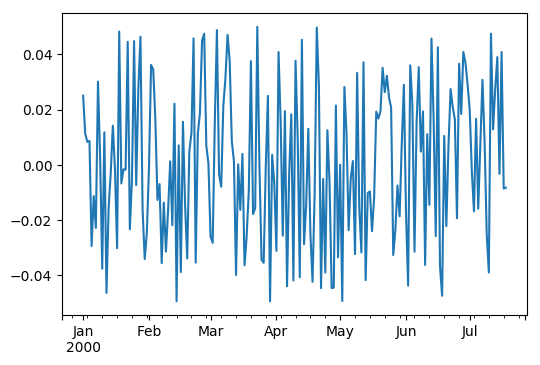

In [7]:
p.Block(df.A.plot())

Raw HTML output

In [8]:
p.Block("<b>this text is bold</b>")

Composing blocks

In [9]:
p.VStack([p.Block("Hello World!", title="Announcement"), p.Block("<b>this text is bold</b>")])

In most cases, one does not need to explicitly wrap elements in blocks

In [10]:
p.Block(["Block %s" % i for i in range(8)])

Splitting composite blocks into columns

In [11]:
p.Block(["Block %s" % i for i in range(8)], cols=4)

Layout styling is cascading - styles will cascade from parent blocks to child blocks by default. This behavior can be disabled by setting *inherit_cfg* to false on the child blocks, or simply specifying the desired settings explicitly.

In [12]:
p.Block(["Block %s" % i for i in range(8)], cols=4, text_align="right")

Using specific block types is simple as well. As an example - the Paragraph block:

In [13]:
p.Block([p.Paragraph("First paragraph."),
         p.Paragraph("Second paragraph."),
         p.Paragraph("Third paragraph.")], text_align="right")

The Pre block preserves whitespace formatting and is rendered using a fixed width font. Useful for rendering code-like text.

In [14]:
p.Pre("""
some:
  example:
    yaml: [1,2,3]
  data: "text"
""")

Creating custom blocks is trivial. For the majority of the cases, one can just inherit from the Container block, which has most of the plumbing already in place:

In [15]:
class Capitalize(p.Raw):
    def __init__(self, contents, **kwargs):
        # Stringify and capitalize
        contents = str(contents).upper()

        super(Capitalize, self).__init__(contents, **kwargs)
        
Capitalize("this here text should look like shouting!")

### Simple line chart
When evaluated as the last expression in a Notebook Cell, the plot is automatically displayed inline.

Note how the plot name (hover over the line to see the little popup) is taken from the input data (if available).

In [16]:
import pybloqs.plot as pp
p.interactive()
pp.Plot(a)

Interactive mode initialized successfully

### Saving as interactive HTML

In [17]:
pp.Plot(a).save("chart_sample.html")

'chart_sample.html'

### Scatter Plot
Regular scatter plot, with zooming on both the x and y axes.

In [18]:
pp.Plot(df.values[:,:2], pp.Scatter(pp.Marker(enabled=True)), pp.Chart(zoom_type="xy"))

###Bar Charts
Notice how when viewing all the data at once, the chart shows monthly data, yet zooming in reveals additional detail at up to daily resolution. This is accomplished by using a custom data grouping.

In [19]:
bar_grouping = pp.DataGrouping(approximation="open", enabled=True, group_pixel_width=100)

In [20]:
# Bar chart from a dataframe
pp.Plot(df, pp.Column(bar_grouping))

# Stacked bar chart
Plot(df, Column(bar_grouping, stacking="normal"))

In [21]:
# Composite bar chart from two separate plots.
s2 = pp.Plot([pp.Plot(a, pp.Column(bar_grouping)),
              pp.Plot(b, pp.Column(bar_grouping))])
s2

### Comparing series in a dataframe
Plot the cumulative percentage difference between input series (or columns of a dataframe). The cumulative difference is always calculated from the start of the observation window. This results in intuitively correct behavior when zooming in or sliding the window, as the chart will dynamically recalculate the values. Incredibly useful for comparing model performance over time for example as one doesn't need to manually normalize money curves for different periods.

In [22]:
s3 = pp.Plot(df_cr,
             pp.PlotOptions(pp.Series(compare="percent")),
             pp.TooltipPct(),
             pp.YAxisPct())
s3

### Three series on separate side-by-side Y axes

In [23]:
s4 = pp.Plot([pp.Plot(a),
            pp.Plot(b, pp.YAxis(pp.Title(text="B Axis"), opposite=True)),
            pp.Plot(c, pp.YAxis(pp.Title(text="C Axis"), opposite=True, offset=40))])
s4

### Two series on separate subplots

In [24]:
s5 = pp.Plot([pp.Plot(a, pp.Line(), pp.YAxis(pp.Title(text="a only"), height=150)),
               pp.Plot(b, pp.Column(), pp.YAxis(pp.Title(text="b only"),
                                                   top=200, height=100, offset=0))],
              pp.Tooltip(value_decimals=2), height="400px")
s5

### Writing out multiple charts as HTML

In [25]:
b = p.Block([p.Block(pt.makeTimeDataFrame().tail(10), title="A table", title_level=1),
           p.Block([s2, s3], title="Side-by-side Plots", cols=2),
           p.Block(title="Full Width Plots", styles={"page-break-before": "always"}),
           p.Block(s4, title="Side by Side Axes"),
           p.Block(s5, title="Composite Plots")], title="Dynamic Reports")

In [26]:
b.save("charts_test.pdf")
b.save("charts_test.html")

['wkhtmltopdf', '--no-stop-slow-scripts', '--debug-javascript', '--javascript-delay', '200', '--page-size', 'A4', '--orientation', 'Portrait', '--enable-smart-shrinking', '/tmp/58954b4c27.html', 'charts_test.pdf'] returned:

None


'charts_test.html'

In [27]:
# Emails the report. The emailing is independent of previous reports being saved (e.g. there is no need to call save
# before emailing).
from smtplib import SMTPServerDisconnected

try:
    b.email(fmt="html")
except SMTPServerDisconnected:
    print("Please create ~/.pybloqs.cfg with entry for smtp_server . See README.md and pybloqs/config.py for details.")

Please create ~/.pybloqs.cfg with entry for smtp_server . See README.md and pybloqs/config.py for details.


### Page break

In [28]:
blocks = [p.Block("First page", styles={"page-break-after": "always"}),
          p.Block("Second page")]
r = p.VStack(blocks)
r.save("two_page_report.pdf")

['wkhtmltopdf', '--no-stop-slow-scripts', '--debug-javascript', '--javascript-delay', '200', '--page-size', 'A4', '--orientation', 'Portrait', '--enable-smart-shrinking', '/tmp/acff3df650.html', 'two_page_report.pdf'] returned:

None


'two_page_report.pdf'